### Lab 4: Multivariate and logistic regression

## 1. Import packages

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression as LinearRegressionSKL
import matplotlib.pyplot as plt

## 1. Helper functions

In [3]:
#An helper function to plot the single variable regression data
def plotSingleRegression(xf, yf, xt, yt, yp):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = 'red')
    plt.plot(xt, yp, '--', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [4]:
#An helper function to plot the single variable regression data, for multiple solutions
def plotSingleRegressionV(xf, yf, xt, yt, yp):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = 'red')
    for ypi in yp:
        plt.plot(xt, ypi, '--', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## 2. IModel hierarchy 

In [5]:
from abc import ABC, abstractmethod
from typing import *
from numpy.typing import NDArray

class IModel(ABC):

    @abstractmethod
    def fit(X : NDArray, y : NDArray) -> None:
        '''
        X is a 2D array with n features accross columns and m data points across rows.
        y is a column vector with m labels, one for each data point in X.
        '''
        pass
    
    @abstractmethod
    def predict(xp : NDArray) -> NDArray:
        '''
        xp is a column vector with k data points, each with n features.
        returns a vector with k predicted labels, one for each data point in vector xp.
        '''
        pass

    
    @abstractmethod
    def theta() -> [None | NDArray]:
        '''
        returns the vector theta with k coefficients after model trained.
        before training returns None
        '''
        pass


## 

In [6]:
class Predictor (IModel):
    '''
    Implements the Normal equation model without regularization
    '''

    #Constructor
    def __init__(self) -> None:
        self._theta = None


    #predict after training
    def predict(self, xp : NDArray) -> NDArray:
        if self._theta is None:
            raise Exception('It is needed to fit model first')
        else:    
            # add a column of 1s 
            xp = self._addOnesLeft(xp)

            # prediction
            return xp.dot(self._theta)

    
    # return values for theta found after training or None
    def theta(self) -> [None | NDArray]:
        return self._theta

    
    # add a column of 1s at the left
    def _addOnesLeft(self, X:NDArray) -> NDArray:
        return np.column_stack((np.ones_like(X[:,0]), X))

In [7]:
class NormalEQ (Predictor):
    '''
    Implements the Normal equation model without regularization
    '''

    #         T     -1    T
    # Θ = ( X . X  )   . X  y
    
    #Fit with normal equation best theta
    def fit(self, X : NDArray, y : NDArray) -> None:
        # add a column of 1s
        X = super()._addOnesLeft(X)
        
        # compute normal equation
        #pinv calculates pseudo inverse
        #useful if there is linear dependent columns
        #eg. one feature is the price in Euros and another feature is the price in Pounds
        self._theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)


In [8]:
class LinearRegression (NormalEQ):
    '''
    Implements multivariate linear regression without regularization, based on the Normal equation model

    just an alias for class NormalEQ
    '''
    pass

In [9]:
class NormalEQReg (Predictor):
    '''
    Implements the Normal equation model with regularization
    '''

    def __init__(self, l:int) -> None:
        if l < 0:
            raise Exception('lambda must be >= 0')
        self._lambda = l
        super().__init__()

    def mse(self, y_true: NDArray, y_pred: NDArray) -> float:
        m = len(y_true)
        return np.sum((y_pred - y_true) ** 2) / m

    
    #https://dev.to/_s_w_a_y_a_m_/linear-regression-using-normal-equation-21co
    #
    #         T          -1     T
    # Θ = ( X . X  + λ R)   . X  y   
    #
    # Where R is an Identity matrix where λ(0,0) = 0
    
    #Fit with normal equation best theta
    def fit(self, X : NDArray, y : NDArray) -> None:
           
        # add a column of 1s
        X = super()._addOnesLeft(X)

        # setup regularization
        R = np.identity(X.shape[1])
        R[0,0] = 0
        
        # compute normal equation
        #pinv calculates pseudo inverse
        #useful if there is linear dependent columns
        #eg. one feature is the price in Euros and another feature is the price in Pounds
        projection_y = (X.T).dot(y)
        cov          = np.linalg.pinv(X.T.dot(X) + np.multiply(self._lambda, R)) 
        self._theta  = cov.dot(projection_y)

## 3. Quiz solution

---
1.	Express the gradient descent update with regularization in vector form:



We start with the gradient descent in vector form, as was achieved in the last Lab:

$$
\theta := \theta - \alpha\frac{1}{m}X^{T}(X\theta-y)
$$

Now we add the L2 regularization parameter, (ridge regression):

We add the regularization term to regularize all parameters except $\theta_{0}$

* $\theta_{0} := \theta_{0} - \alpha\frac{1}{m}X^{T}(X\theta-y)$

* $\theta_{j} := \theta_{j}(1-\alpha\frac{\lambda}{m})-\alpha\frac{1}{m}X^{T}(X\theta-y)$

where j represents all the parametes except $\theta0$

We can the represent the L2 regularization parameter for all parameters using:

$
R = \begin{bmatrix}
1 & 0 & 0 & ... & 0 \\
0 & 1-\alpha\frac{\lambda}{m} & 0 & ... & 0 \\
0 & 0 & 1-\alpha\frac{\lambda}{m} & ... & 0 \\
... & ... & ... & ... & ... \\
0 & 0 & 0 & ... & 1-\alpha\frac{\lambda}{m}
\end{bmatrix}
$

Using this matrix **R**, we can now rewerite the gradient descent update rule with regularization in a single vectorized form

$$
\theta := R\theta - \alpha\frac{1}{m}X^{T}(X\theta-y)
$$

* **R**$\theta$: Scales each $\theta_{j}$ for j > 0 by (1 - $\alpha\frac{\lambda}{m}$)



---
2. Load  the  dataset  in  the  companion  file  demodataset.csv.  Shuffle  it  and  divide  it  into  disjoint 
training and testing datasets

In [10]:
data = np.loadtxt('demodataset.csv', delimiter=',')

rng = np.random.default_rng(0) # random seed
rng.shuffle(data)

train_data = data[:int((0.7*len(data)))]
test_data = data[int((0.7*len(data))):]

x_train=train_data[:,0] # x is the first  column in the data set
y_train=train_data[:,1] # y is the second column in the data set

x_test=test_data[:,0] # x is the first  column in the test data set
y_test=test_data[:,1] # y is the second column in the test data set

x_train = x_train.reshape(len(x_train),1)
y_train = y_train.reshape(len(x_train),1)

x_test = x_test.reshape(len(x_test),1)
y_test = y_test.reshape(len(y_test),1)

#plt.plot(x_train, y_train, "+", color = "blue")
#plt.plot(x_test, y_test, "+", color = "red")
#plt.show()

---
3.

a) Implement a linear (in the parameters) basis function regression model using the Gradient descent model with regularization, with a new Classifier subclass named GradDescReg

In [11]:
class GradDescReg(Predictor):

    def __init__(self, lambda_: int, maxIter: int = 100000, convDiff: float = 10**-8, alpha: float = 0.01):
        self.lambda_ = lambda_          # Regularization strength (lambda)
        self.maxIter = maxIter          # Maximum iterations for gradient descent
        self.convDiff = convDiff        # Convergence criteria
        self.alpha = alpha              # Learning rate
        self._theta = None               # Model parameters (weights)

    def checkConvergence(self, old_theta: np.ndarray, new_theta: np.ndarray) -> bool:
        diff = np.subtract(self._theta, old_theta)
        return np.all(diff < self.convDiff)
    
    def mse(self, y_true: NDArray, y_pred: NDArray) -> float:
        m = len(y_true)
        return np.sum((y_pred - y_true) ** 2) / m

    def fit(self, X : NDArray, y : NDArray) -> None:
        X = super()._addOnesLeft(X)
        m, n = X.shape
        
        self._theta = np.zeros((n, 1)) # Initialize theta with zeros
        
        regularization_factor = 1 - ((self.alpha * self.lambda_) / m)
        
        for i in range(self.maxIter):
            old_theta = self._theta.copy() # save old theta for convergence check
            
            h = np.dot(X, self._theta) # hypothesis vector
            r = np.subtract(h, y) # residuals vector
            s = np.dot(X.T, r)
            
            # This is the regularization part of the vectorized gradient descent. 
            theta0tmp = self._theta[0] # Save old theta 0 value to not regularize it
            self._theta = np.multiply(self._theta, regularization_factor) # Regularize all theta values, but replace in the next step
            self._theta[0] = theta0tmp # Restore old theta 0 value so only theta 1 to n are regularized
            
            self._theta = np.subtract(self._theta, np.multiply(self.alpha/m, s)) 
            
            # Calculate the difference between the new and old theta and check for convergence
            if self.checkConvergence(old_theta, self._theta):
                break

b) Using **GradDescReg** class, fit the regression model to the training set  and predict with 
the test dataset, for values of the regularization term λ = [0, 200], with resolution 1. 
Plot the mean square error (mse) for the test dataset for all values of λ. 
What is the λ that minimizes the mse?

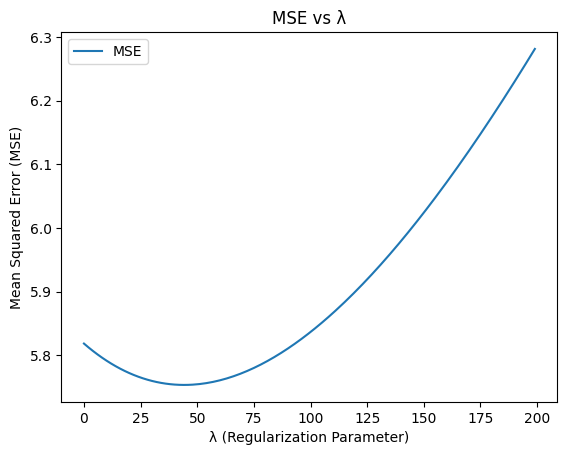

The lambda that minimizes the mse is: 44


In [12]:
lambdas = range(0, 200)  # λ values from 0 to 200 with a step of 1
mse_values = []

for lambda_ in lambdas:
    model = GradDescReg(lambda_=lambda_)
    model.fit(x_train, y_train)  
    y_pred = model.predict(x_test) 
    mse = model.mse(y_test, y_pred) 
    mse_values.append(mse)

plt.plot(lambdas, mse_values, label='MSE')
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs λ')
plt.legend()
plt.show()
print("The lambda that minimizes the mse is: " + str(mse_values.index(min(mse_values))))

c) Plot the train dataset, test datasets, and the regression for the λ that minimizes the mse
obtained in b).


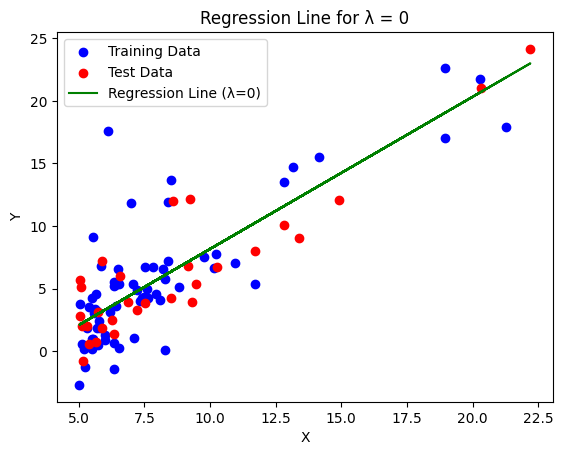

In [13]:
# Assuming optimal_lambda is the value of λ that minimized MSE in the previous step
optimal_lambda = 0  # From previous step if λ = 0 minimized MSE
model = GradDescReg(lambda_=optimal_lambda)
model.fit(x_train, y_train)

# Predict values for training and test sets
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Plot the training data
plt.scatter(x_train, y_train, color='blue', label='Training Data')
plt.scatter(x_test, y_test, color='red', label='Test Data')

# Plot the regression line for the optimal lambda
x_all = np.vstack((x_train, x_test))  # Combine train and test sets for plotting
y_all_pred = model.predict(x_all)
plt.plot(x_all, y_all_pred, color='green', label=f'Regression Line (λ={optimal_lambda})')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Regression Line for λ = {optimal_lambda}')
plt.legend()
plt.show()


d) Repeat b) with the NormalEQReg class. 

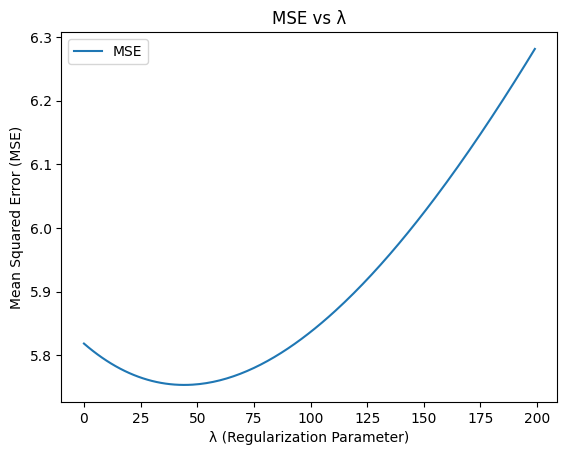

The lambda that minimizes the mse is: 44


In [14]:
lambdas = range(0, 200)  # λ values from 0 to 200 with a step of 1
mse_values = []

for lambda_ in lambdas:
    model = NormalEQReg(lambda_)
    model.fit(x_train, y_train)  
    y_pred = model.predict(x_test) 
    mse = model.mse(y_test, y_pred) 
    mse_values.append(mse)

plt.plot(lambdas, mse_values, label='MSE')
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs λ')
plt.legend()
plt.show()
print("The lambda that minimizes the mse is: " + str(mse_values.index(min(mse_values))))



e) Compare the results in c) and d)

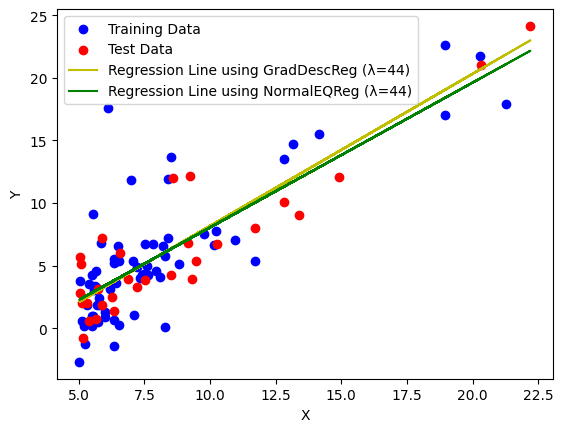

In [15]:
# Assuming optimal lambda = 44 for the Gradient Descent model
optimal_lambda_gd = 44 
modelgd = GradDescReg(lambda_=optimal_lambda)
modelgd.fit(x_train, y_train)

# Assuming optimal lambda = 44 for the Normal Equation model
optimal_lambda = 44
modelneq = NormalEQReg(l=optimal_lambda)
modelneq.fit(x_train, y_train)

# Predict values for training and test sets in gradient descent model
y_train_pred = modelgd.predict(x_train)
y_test_pred = modelgd.predict(x_test)

# Predict values for training and test sets in normal equation model
y_train_pred = modelneq.predict(x_train)
y_test_pred = modelneq.predict(x_test)

# Plot the training data
plt.scatter(x_train, y_train, color='blue', label='Training Data')
plt.scatter(x_test, y_test, color='red', label='Test Data')

# Plot the regression line for the optimal lambda for gradient descent model
x_all_gd = np.vstack((x_train, x_test))  # Combine train and test sets for plotting
y_all_pred_gd = modelgd.predict(x_all)
plt.plot(x_all_gd, y_all_pred_gd, color='y', label=f'Regression Line using GradDescReg (λ={optimal_lambda_gd})')

# Plot the regression line for the optimal lambda for normal equation model
x_all_neq = np.vstack((x_train, x_test))  # Combine train and test sets for plotting
y_all_pred_neq = modelneq.predict(x_all)
plt.plot(x_all_neq, y_all_pred_neq, color='green', label=f'Regression Line using NormalEQReg (λ={optimal_lambda})')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


* They are very simmilar

4. 

In [20]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRegression(Predictor):

    def __init__(self, lambda_: int, maxIter: int = 100000, convDiff: float = 10**-8, alpha: float = 0.01):
        self.lambda_ = lambda_          # Regularization strength (lambda)
        self.maxIter = maxIter          # Maximum iterations for gradient descent
        self.convDiff = convDiff        # Convergence criterion
        self.alpha = alpha              # Learning rate
        self._theta = None               # Model parameters (weights)

    def checkConvergence(self, old_theta: np.ndarray, new_theta: np.ndarray) -> bool:
        diff = np.linalg.norm(new_theta - old_theta)
        return diff < self.convDiff
    
    def mse(self, y_true: NDArray, y_pred: NDArray) -> float:
        m = len(y_true)
        return np.sum((y_pred - y_true) ** 2) / m

    def fit(self, X : NDArray, y : NDArray) -> None:
        X = self._addOnesLeft(X)
        m, n = X.shape
        
        self._theta = np.zeros((n, 1)) # Initialize theta with zeros
        
        regularization_factor = 1 - ((self.alpha * self.lambda_) / m)
        
        for i in range(self.maxIter):
            old_theta = self._theta.copy() # save old theta for convergence check
            
            h = sigmoid(np.dot(X, self._theta)) # hypothesis vector
            r = np.subtract(h, y) # residuals vector
            s = np.dot(X.T, r)
            
            # This is the regularization part of the vectorized gradient descent. 
            theta0tmp = self._theta[0] # Save old theta 0 value to not regularize it
            self._theta = np.multiply(self._theta, regularization_factor) # Regularize all theta values, but replace in the next step
            self._theta[0] = theta0tmp # Restore old theta 0 value so only theta 1 to n are regularized
            
            self._theta = np.subtract(self._theta, np.multiply(self.alpha/m, s)) 
            
            # Calculate the difference between the new and old theta and check for convergence
            if self.checkConvergence(old_theta, self._theta):
                break

    def predict(self, xp : NDArray) -> NDArray:
        if self._theta is None:
            raise Exception('It is needed to fit model first')
        else:    
            # add a column of 1s 
            xp = self._addOnesLeft(xp)

            # prediction
            return sigmoid(xp.dot(self._theta))
            

# Example dataset
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [1]])  # Target labels

# Create and train logistic regression model
log_reg = LogisticRegression(44)
log_reg.fit(x, y)

# Predict probabilities and binary outcomes for new data
x_new = np.array([[0.5, 0.5]])


prediction = log_reg.predict(x_new)

print(f"Predicted class: {prediction[0][0]}")


Predicted class: 0.7500020043970734


5. Load the companion data file lab04data.csv in the format {(x1(i),x2(i), y(i)) | i=1,..., m} where x1 
and x2 are the independent variables and y denotes the corresponding class. 
    a) Plot the 2 available classes in the space x1, x2

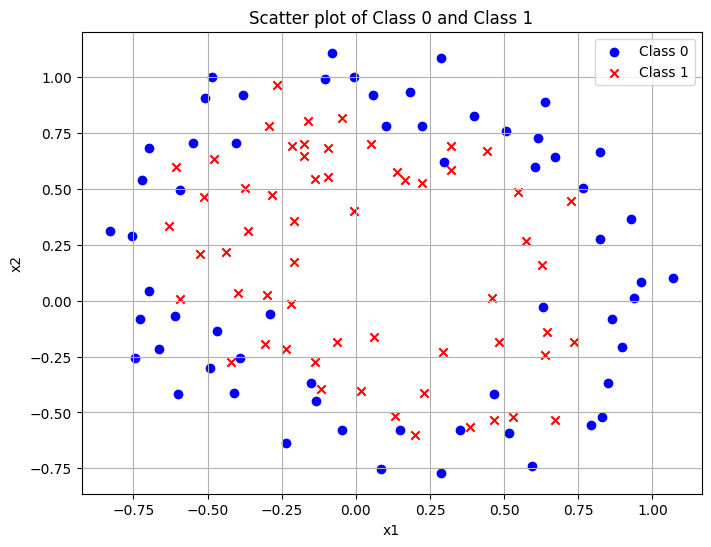

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from CSV
data = np.loadtxt('lab04data.csv', delimiter=',')

# Separate x1, x2, and y columns
x1 = data[:, 0]
x2 = data[:, 1]
y = data[:, 2]

# Separate the classes
class_0 = data[y == 0]  # Select rows where y == 0
class_1 = data[y == 1]  # Select rows where y == 1

# Plot the two classes
plt.figure(figsize=(8, 6))
plt.scatter(class_0[:, 0], class_0[:, 1], label='Class 0', color='blue', marker='o')
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', color='red', marker='x')

# Add labels and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter plot of Class 0 and Class 1')
plt.legend()
plt.grid(True)
plt.show()


b) Apply  regularized  logistic  regression  using  the  following  feature  vector:  [1  x1  x2  x12 
x1*x2 x22 x13 ... x15*x2 x26]’ (28 elements overall) – see the companion file map.py – 
and a suitable λ value. Visualize the boundary decision  
 
 

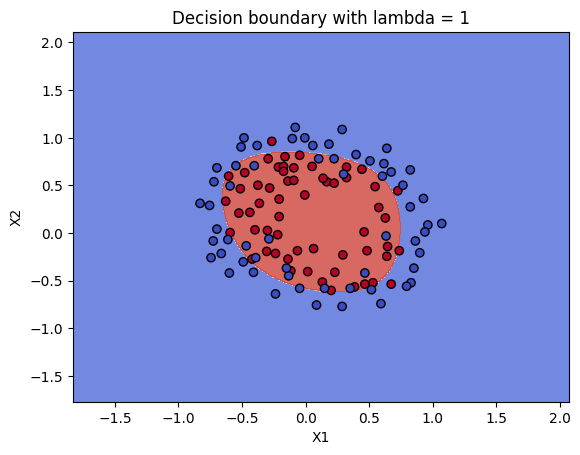

In [19]:
# Load the data from CSV using numpy
data = np.loadtxt('lab04data.csv', delimiter=',')
X1 = data[:, 0]  # First column
X2 = data[:, 1]  # Second column
y = data[:, 2]   # Third column

# Define mapFeature function for polynomial feature mapping
def mapFeature(X1, X2, degree=6):
    """
    Feature mapping function to polynomial features.
    Maps the two input features to quadratic features used in regularization.

    Returns a new feature array with more features, comprising of 
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    """
    m = X1.shape[0]
    out = np.ones((m, 1))  # Start with a column of ones for the intercept term
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out = np.hstack((out, (X1 ** (i - j) * X2 ** j).reshape(-1, 1)))
    return out

# Create feature-mapped X values
X_mapped = mapFeature(X1, X2)

# Placeholder RegLogReg class
class RegLogReg:
    def __init__(self, lambda_, max_iter):
        self.lambda_ = lambda_
        self.max_iter = max_iter
        self.theta = None

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros((n, 1))
        y = y.reshape(-1, 1)
        
        for _ in range(self.max_iter):
            h = 1 / (1 + np.exp(-np.dot(X, self.theta)))  # Sigmoid function
            gradient = (1 / m) * np.dot(X.T, (h - y)) + (self.lambda_ / m) * np.vstack([[0], self.theta[1:]])
            self.theta -= 0.01 * gradient  # Learning rate set as 0.01

    def predict(self, X1, X2):
        X_mapped = mapFeature(X1, X2)
        linear_combination = np.dot(X_mapped, self.theta)
        return (linear_combination >= 0).astype(int)  # Returns 0 or 1 based on decision boundary

# Apply regularized logistic regression
lambda_value = 1
log = RegLogReg(lambda_value, 150000)
log.fit(X_mapped, y)

# Define function to plot decision boundary
def plot_decision_boundary(log, X1, X2, y):
    # Set min and max values and give it some padding
    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    # Predict the function value for the whole grid
    Z = log.predict(xx.ravel(), yy.ravel())
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X1, X2, c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f'Decision boundary with lambda = {lambda_value}')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Plot decision boundary
plot_decision_boundary(log, X1, X2, y)
plt.show()
